## Manual 2d data loading

This example will teach you how to manually load the 2d output files.

First, lets get the number of cells in each direction of the grid by loading the dimensions.dat file.

In [ ]:
import numpy as np
datadir = "../output/out"
dimensions = {k:v for k,v in zip(
    ["RMIN", "RMAX" ,"PHIMIN", "PHIMAX", "NRAD" ,"NAZ","NGHRAD","NGHAZ","Radial_spacing"],
    np.genfromtxt(datadir + "/dimensions.dat", dtype=[float, float, float, float, int, int, int, int, 'S20'])[()])}
Nrad = dimensions["NRAD"]
Naz = dimensions["NAZ"]


Next, load the base units from the units.dat file.

In [ ]:
dimensions

{'RMIN': 0.4,
 'RMAX': 2.5,
 'PHIMIN': 0.0,
 'PHIMAX': 6.283185307179586,
 'NRAD': 128,
 'NAZ': 384,
 'NGHRAD': 1,
 'NGHAZ': 1,
 'Radial_spacing': b'Logarithmic'}

In [ ]:
units = {}
with open(datadir + "/units.dat") as infile:
    for line in infile:
        line = line.strip()
        if line[0] == "#":
            continue
        cols = line.split()
        if len(cols) < 2:
            continue
        units[cols[0]] = " ".join(cols[1:])
units

{'length': '1.4959787070000000e+13 cm',
 'mass': '1.9884699999999999e+33 g',
 'time': '5.0225669513368811e+06 s',
 'temperature': '1.0670018430261180e+05 K'}

Finally, lets load some data from an output file.
We'll start with surface density from snapshot number 2.

In [ ]:
Nsnap = 2
datafile = datadir + f"/snapshots/{Nsnap}/Sigma.dat"
Sigma_raw = np.fromfile(datafile, dtype=np.float64)
Sigma_raw.shape

(49152,)

The data is stored on disk as a 1D-array, so we need to reshape it to the correct 2d form.

In [ ]:
Sigma_reshaped = Sigma_raw.reshape(Nrad, Naz)
Sigma_reshaped.shape

(128, 384)

At this point, the values are in code units, which can be anything.
Because we have all the unit information loaded already, we can convert the values to something more understandable.
I suggest using the astropy library to handle the unit conversions.

In [ ]:
import astropy.units as u
L0 = u.Unit(units["length"])
M0 = u.Unit(units["mass"])
T0 = u.Unit(units["time"])
print("L0 =", L0)
print("M0 =", M0)
print("T0 =", T0)

L0 = 1.49598e+13 cm
M0 = 1.98847e+33 g
T0 = 5.02257e+06 s


In [ ]:
Sigma = Sigma_reshaped * M0 / L0**2
Sigma[0][0]

<Quantity 0.00033442 8.88522e+06 g / cm2>

Now the values carry a unit, though this is still the code unit for surface density.
The Sigma variable now points to an astropy.units.Quantity object, which is a numpy array with some extra information like the unit and some extra methods to convert these units.

In [ ]:
Sigma = Sigma.to("g/cm2")
Sigma[0][0]

<Quantity 2971.4156036 g / cm2>

Before we construct a grid, lets have a look at the data.

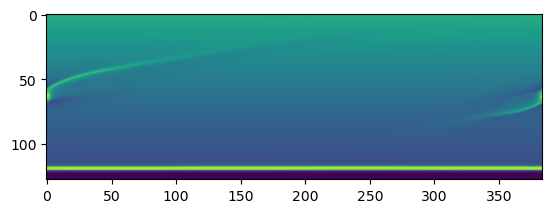

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Sigma)

Fargo only stores basic information about the grid which we already loaded above.
We will now construct arrays with the coordinates on the cell interfaces.

In [ ]:
if dimensions["Radial_spacing"] == b'Logarithmic':
    ri = np.geomspace(dimensions["RMIN"], dimensions["RMAX"], Nrad+1)
else:
    ri = np.linspace(dimensions["RMIN"], dimensions["RMAX"], Nrad+1)
ri = ri*L0

phii = np.linspace(dimensions["PHIMIN"], dimensions["PHIMAX"], Naz+1)

Now we have all information to make a colormap plot of the surface density.

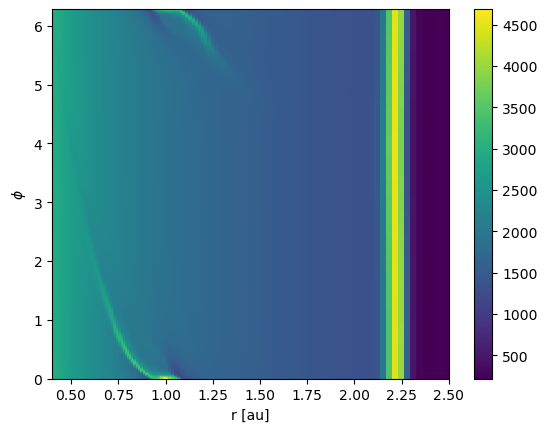

In [ ]:
Ri, Phii = np.meshgrid(ri, phii, indexing="ij")
pcm = plt.pcolormesh(Ri.to_value("au"), Phii, Sigma.to_value("g/cm2"))
plt.xlabel("r [au]")
plt.ylabel(r"$\phi$")
cbar = plt.colorbar(pcm)

The surface density values are defined on the cell center locations.
Fargo uses a staggered grid, which means that the velocities are defined on the cell interfaces.
The radial velocity is defined on the radial cell interfaces and the azimuthal velocity is defined on the azimuthal cell interfaces.
As a result, there are more values in the radial velocity array because there is one more radial interface location compared to radial center locations. This means the respective array has Naz more values.
Let's see for ourselves.

In [ ]:
Nsnap = 2
datafile = datadir + f"/snapshots/{Nsnap}/vrad.dat"
vrad_raw = np.fromfile(datafile, dtype=np.float64)
vrad_raw.shape

(49536,)

In [ ]:
print("len(Sigma_raw) =", len(Sigma_raw))
print("len(vrad_raw) =", len(vrad_raw))

len(Sigma_raw) = 49152
len(vrad_raw) = 49536


In [ ]:
len(vrad_raw) - len(Sigma_raw)

384

In [ ]:
Naz

384

Again, reshape and apply units.

In [ ]:
vrad_reshaped = vrad_raw.reshape(Nrad+1, Naz)
vrad = vrad_reshaped * L0 / T0

For the azimuthal velocity, there are as many values as in the surface density array.
This is because the azimuthal boundary is periodic, so we do not need to store both the the values on the first and the last interface locations since these values are identical by construction.
The energy values are also defined at the cell centers, so its the same procedure as for the surface density.